#   QC start
1. Parse data, attempt compression
2. Insert new QARTOD 2 flags
3. Metadata checks
    * Spatiotemporal checks - check ranges, ID when the deployment ends and flag everything before then
4. Data stream checks: Noise, offline or static
5 Outlier flagging
6. Despiking
7. Window filters
8. Point flag variable (based on all previous flag results)

Later

9. Property-property checks (linear regressions)
10. QC automated report from 1-9
    * QC automated plots: TS, BGC profiles, time, geospatial
    * Define QC plot formatting - "apply_fmt" for axis colors, fonts, etc.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from hashlib import md5
from pathlib import Path

Note that for this notebook, I've dedicated seperate `data` and `reporting` folders for things to live in.

##  1. Parsing data and compression
Load the dataset into Xarray.

Check to see if it can be compressed in the same way `odf.sbe` was working.

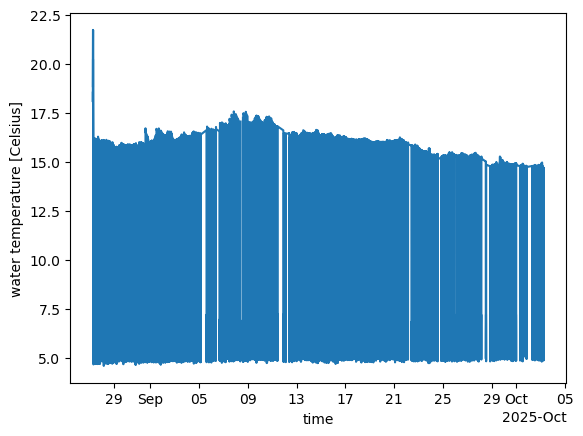

In [2]:
path = 'data/078_mission_timeseries.nc'
nrt = xr.open_dataset(path)
nrt['temperature'].plot.line()

In [3]:
#   Some basic encoding and integrity attributes
encoding = "CP437"
content_md5 = True
nrt.attrs["qc_filename"] = path
if content_md5:
    nrt.attrs["Content-MD5"] = md5(Path(path).read_bytes()).hexdigest() #   For storage integrity checks prior to adjustments
nrt.attrs["charset"] = encoding

In [4]:
#   Compression - does it save space?
nrt.encoding["zlib"] = True
nrt.encoding["complevel"] = 6
#   Could go further with chunksizes, but the resolution on nrt is already pretty low

In [5]:
nrt.to_netcdf("data/compressed.nc")

In [6]:
size_original = Path(path).stat().st_size
size_compressed = Path("data/compressed.nc").stat().st_size
print(f"Original size: {size_original} bytes")
print(f"Compressed size: {size_compressed} bytes")
print(f"Compression ratio: {size_original / size_compressed:.2f}")

Original size: 8111701 bytes
Compressed size: 8115884 bytes
Compression ratio: 1.00


Sooooo no compression really needs to be done. At some point, we're compressing it.

##  2. Insert new QARTOD QC variables for flagging
Init to 2

Question for the office: Does it make sense to QC derived variables?
* Depth
* Salinity
* Potential density
* Density
* Potential temperature

Are these not derived from P, T, S? Therefore, shouldn't flags "trickle" from sources into products?

IMO, we should QC the base, then derive everything with GSW with flags based on the sources

In [7]:
list(nrt.variables)

['ad2cp_beam1_cell_number1',
 'ad2cp_beam2_cell_number1',
 'ad2cp_beam3_cell_number1',
 'ad2cp_beam4_cell_number1',
 'ad2cp_heading',
 'ad2cp_pitch',
 'ad2cp_pressure',
 'ad2cp_roll',
 'ad2cp_time',
 'altimeter',
 'backscatter',
 'chlorophyll',
 'conductivity',
 'downwelling_PAR',
 'internal_temperature_PAR',
 'nav_resource',
 'oxygen_ad_counts',
 'oxygen_concentration',
 'oxygen_led_counts',
 'phycocyanin',
 'pressure',
 'temperature_oxygen',
 'angular_cmd',
 'angular_pos',
 'ballast_cmd',
 'ballast_pos',
 'dead_reckoning',
 'declination',
 'desired_heading',
 'dive_num',
 'heading',
 'internal_pressure',
 'internal_temperature',
 'linear_cmd',
 'linear_pos',
 'nav_state',
 'pitch',
 'roll',
 'salinity',
 'security_level',
 'temperature',
 'voltage',
 'distance_over_ground',
 'potential_density',
 'density',
 'potential_temperature',
 'pressure_qc',
 'depth_qc',
 'temperature_qc',
 'salinity_qc',
 'conductivity_qc',
 'oxygen_concentration_qc',
 'chlorophyll_qc',
 'longitude_qc',
 'lat

In [8]:
#   Will want to check out `time` separately
qc_vars = [name for name in nrt.data_vars if "_qc" in name]
qc_vars

['pressure_qc',
 'depth_qc',
 'temperature_qc',
 'salinity_qc',
 'conductivity_qc',
 'oxygen_concentration_qc',
 'chlorophyll_qc',
 'longitude_qc',
 'latitude_qc',
 'potential_density_qc',
 'density_qc',
 'potential_temperature_qc',
 'phycocyanin_qc']

In [9]:
qc_vars = qc_vars + ["time"]  #   Adding time separately
for qc_todo in qc_vars:
    qc_name = qc_todo + "_qartod"
    if qc_name == 'time_qartod':
        qc_name = 'time_qc_qartod'
    nrt[qc_name] = (nrt[qc_todo].dims, np.full(nrt[qc_todo].shape, 2, dtype=np.int8))   #   Init to 2
qc_vars_new = [name for name in nrt.data_vars if "qartod" in name]   #   list(nrt.variables)
qc_vars_new

['pressure_qc_qartod',
 'depth_qc_qartod',
 'temperature_qc_qartod',
 'salinity_qc_qartod',
 'conductivity_qc_qartod',
 'oxygen_concentration_qc_qartod',
 'chlorophyll_qc_qartod',
 'longitude_qc_qartod',
 'latitude_qc_qartod',
 'potential_density_qc_qartod',
 'density_qc_qartod',
 'potential_temperature_qc_qartod',
 'phycocyanin_qc_qartod',
 'time_qc_qartod']

In [10]:
def xr_describe(da):
    #   For basic statistics a la pandas describe()
    #   da = Data Array
    return {
        "count": da.count().item(),
        "mean": da.mean().item(),
        "std": da.std().item(),
        "min": da.min().item(),
        "25%": da.quantile(0.25).item(),
        "50%": da.quantile(0.50).item(),
        "75%": da.quantile(0.75).item(),
        "max": da.max().item(),
    }

In [11]:
for var in qc_vars:
    if var == 'time':
        continue    #   dtype='datetime64[ns]'
    print(f"{var}: {xr_describe(nrt[var])} \n")

pressure_qc: {'count': 29094, 'mean': 1.0149171352386475, 'std': 0.17329326272010803, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 4.0} 

depth_qc: {'count': 29094, 'mean': 1.0145734548568726, 'std': 0.1712709665298462, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 4.0} 

temperature_qc: {'count': 29094, 'mean': 1.0206228494644165, 'std': 0.202036514878273, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 3.0} 

salinity_qc: {'count': 29094, 'mean': 1.008146047592163, 'std': 0.1500343531370163, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 4.0} 

conductivity_qc: {'count': 29094, 'mean': 1.0062899589538574, 'std': 0.13730163872241974, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 4.0} 

oxygen_concentration_qc: {'count': 29094, 'mean': 2.567814588546753, 'std': 1.4623587131500244, 'min': 1.0, '25%': 1.0, '50%': 3.0, '75%': 4.0, 'max': 4.0} 

chlorophyll_qc: {'count': 29094, 'mean': 1.006771206855774, 'std': 0.12184572219848633, 'min': 1.0, '25

In [12]:
#   Proves that the new variables are initialized to 2
for var in qc_vars_new:
    print(f"{var}: {xr_describe(nrt[var])} \n")

pressure_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

depth_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

temperature_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

salinity_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

conductivity_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

oxygen_concentration_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

chlorophyll_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

longitude_qc_qartod: {'count': 29094, 'mean': 2.0, 'std': 0.0, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 2} 

latitude_qc_qartod: 

## 20251202 Init logging and reporting
Doing this first because Callum wants to talk about Sphinx tomorrow. I should make sure it and logging are working on my machine before we discuss.
https://www.sphinx-doc.org/en/master/

Let's see if I remember how to init [logging](https://docs.python.org/3/library/logging.html)...

In [13]:
import logging

def build_logger(log_loc="reporting/qc_log.txt", overwrite=False):
    for h in logging.root.handlers[:]:
        logging.root.removeHandler(h)

    mode = 'w' if overwrite else 'a'
    logging.basicConfig(
        filename=log_loc,
        filemode=mode,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logger = logging.getLogger()
    return logger
logger = build_logger(overwrite=True)

In [14]:
logger.warning("This is a warning message.")    #   Every time I run this cell, a new "WARNING" line should be added

Ok so we've got a way to track statistics in a low-memory way. Good. For the docs that I'd like to have, I'll want Sphinx to be able to generate some plots. So let's get some started, at the base we'll want to have property-property plots.

In [15]:
def property_property(ds, var1, var2, var3=None, savename=None):   #   From previous testing
    if var3 is not None:
        sc = plt.scatter(ds[var1], ds[var2], c=ds[var3], cmap='viridis')
        cmaplabel = str(var3 + ": " + ds[var3].attrs.get('units', 'N/A'))
        plt.colorbar(sc, label=cmaplabel)
    else:
        plt.scatter(ds[var1], ds[var2])
    if var2 == 'pressure' or var2 == 'depth':
        plt.gca().invert_yaxis()
    plt.xlabel(f"{var1}: {ds[var1].attrs.get('units', 'N/A')}")
    plt.ylabel(f"{var2}: {ds[var2].attrs.get('units', 'N/A')}")
    if savename is not None:
        plt.savefig(savename, format="png", bbox_inches="tight")

And next lets just bring up the old scipy median filter, which does both a bit of despiking and a bit of filtering. This should produce something different from the base data that we can then start flagging against.

In [16]:
import scipy.ndimage as ndi

temp_filtered = ndi.median_filter(nrt['temperature'], size=5)   #   This is NEW. Not overwriting the previous data, just using this for flagging

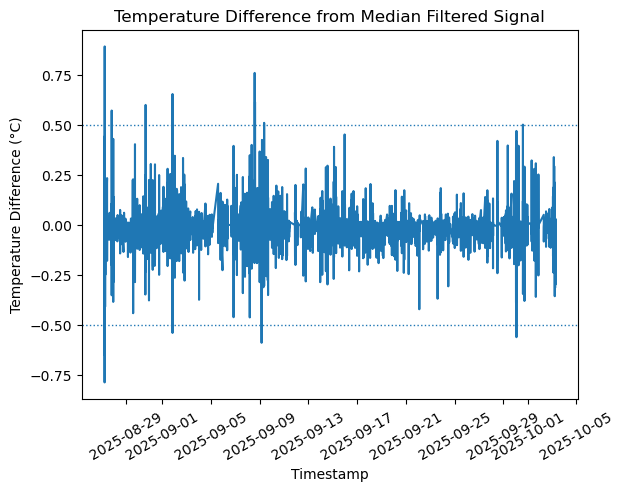

In [17]:
t_delta = nrt.temperature - temp_filtered   #   Simple residual tolerance check
fig, ax = plt.subplots()
ax.plot(nrt.time, t_delta)
plt.xlabel("Timestamp")
ax.tick_params(axis='x', rotation=30)
plt.ylabel("Temperature Difference (°C)")
plt.title("Temperature Difference from Median Filtered Signal")
ax.axhline(y=0.5, linestyle=":", linewidth=1)   #   Completely arbitrary tolerances that will definitely change
ax.axhline(y=-0.5, linestyle=":", linewidth=1)

fig.savefig("reporting/temperature_delta.png", format="png", bbox_inches="tight")   #   Eventually we'll want .SVG

In [18]:
#   ...aaaand let's go ahead and just flag those points that exceed +/- 0.5°C from the filtered signal 
high_deviation = np.abs(t_delta) > 0.5  #   This should probably be constrained
nrt['temperature_qc_qartod'] = nrt['temperature_qc_qartod'].where(~high_deviation, other=4)   #   Is this a 3 or a 4?
print(f"New flags: {xr_describe(nrt["temperature_qc_qartod"])}")
print(f"Old flags: {xr_describe(nrt["temperature_qc"])}")
logger.info(f"Temperature QC updated: {np.sum(high_deviation).item()} points flagged as bad (4) due to high deviation from median filter.")

New flags: {'count': 29094, 'mean': 2.0010998831374165, 'std': 0.04688876765193692, 'min': 2, '25%': 2.0, '50%': 2.0, '75%': 2.0, 'max': 4}
Old flags: {'count': 29094, 'mean': 1.0206228494644165, 'std': 0.202036514878273, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 1.0, 'max': 3.0}


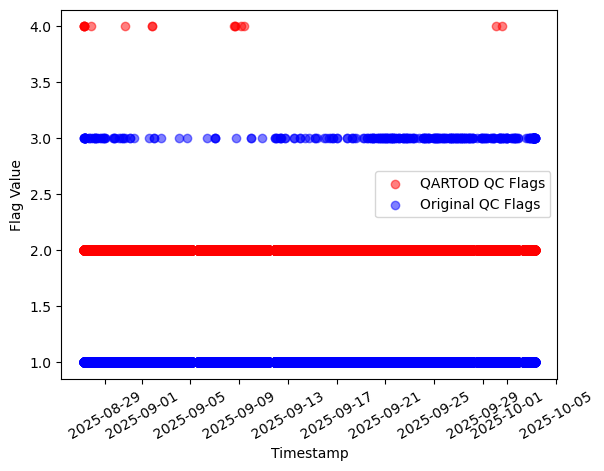

In [19]:
#   Let's make one more plot to visualize the flags
fig, ax = plt.subplots()
ax.scatter(nrt.time, nrt.temperature_qc_qartod, c='red', label='QARTOD QC Flags', alpha=0.5)
ax.scatter(nrt.time, nrt.temperature_qc, c='blue', label='Original QC Flags', alpha=0.5)
plt.legend()
plt.xlabel("Timestamp")
ax.tick_params(axis='x', rotation=30)
plt.ylabel("Flag Value")

fig.savefig("reporting/temperature_flag_example.png", format="png", bbox_inches="tight")

And just as a reminder, at the end of the QC we ideally won't have anything QC'ed as 2.

I wanna make a quick plot of AOU as well. This has been showing up a lot lately. As per my notes, it's an indicator of the physical "potential oxygen", minus any remineralization effects. So AOU = how much there'd be minus the amount consumed by bio/respiration.

In [20]:
#   As per Estel's slide definition, AOU = (O2 solubility at in situ T and S) - (measured O2)
#   O2 solubility can be calculated using Garcia and Gordon (1992) equation
def o2_solubility(temp_c, sal):
    #   Garcia and Gordon (1992) equation for O2 solubility in seawater
    A1 = 2.00907
    A2 = 3.22014
    A3 = 4.05010
    A4 = 4.94457
    A5 = -0.256847
    A6 = 3.88767
    B1 = -0.00624523
    B2 = -0.00737614
    B3 = -0.0103410
    B4 = -0.00817083
    C0 = -4.88682e-7

    temp_k = temp_c + 273.15  # Convert to Kelvin

    ln_o2_sol = (A1 + A2 * (100 / temp_k) + A3 * np.log(temp_k / 100) +
                  A4 * (temp_k / 100) + A5 * (temp_k / 100) ** 2 +
                  A6 * (temp_k / 100) ** 3 +
                  sal * (B1 + B2 * (temp_k / 100) + B3 * (temp_k / 100) ** 2 +
                         B4 * (temp_k / 100) ** 3) +
                  C0 * sal ** 2)

    o2_sol = np.exp(ln_o2_sol)  # in ml/l
    return o2_sol   #   Lol the ai just wrote all this. How to disable?

In [21]:
#   However, why reinvent the wheel when we have gsw?
import gsw
import pandas as pd #   Indexing with xarray is surprisingly clunky. I just wanna see what a typical lat/lon looks like

df = nrt.to_dataframe()
print(df[['temperature', 'salinity', 'pressure', 'longitude', 'latitude']].iloc[499])

temperature     5.310485
salinity        7.279022
pressure       43.449299
longitude      19.847134
latitude       58.124317
Name: 2025-08-27 15:38:41.832999936, dtype: float64


Word of warning (I've never dug into the weeds on this method before): gsw [`O2sol`](https://www.teos-10.org/pubs/gsw/html/gsw_O2sol.html) is supposedly not approved with SCOR or by IAPSO. It supposedly "seems" like the oceanographic best practice. Is there one?

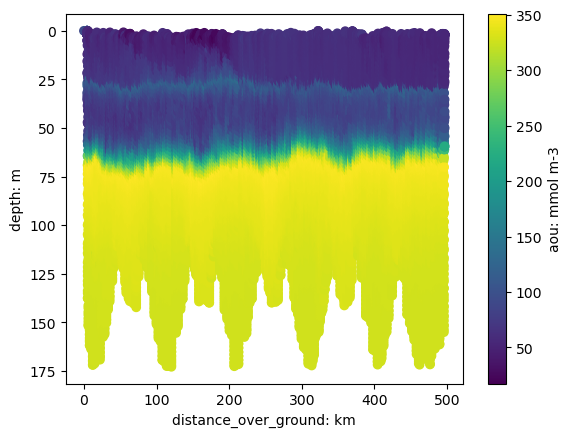

In [22]:
SA = gsw.SA_from_SP(nrt['salinity'], nrt['pressure'], nrt['longitude'], nrt['latitude'])
CT = gsw.CT_from_t(SA, nrt['temperature'], nrt['pressure'])
O2sol = gsw.O2sol(CT, SA, nrt['pressure'], nrt['latitude'], nrt['longitude'])
O2sol.attrs['units'] = nrt['oxygen_concentration'].attrs.get('units', None)
AOU = O2sol - nrt['oxygen_concentration']
AOU.attrs['units'] = nrt['oxygen_concentration'].attrs.get('units', None)
nrt['o2sol'] = O2sol
nrt['aou'] = AOU

property_property(nrt, 'distance_over_ground', 'depth', 'aou', savename="reporting/aou.png")

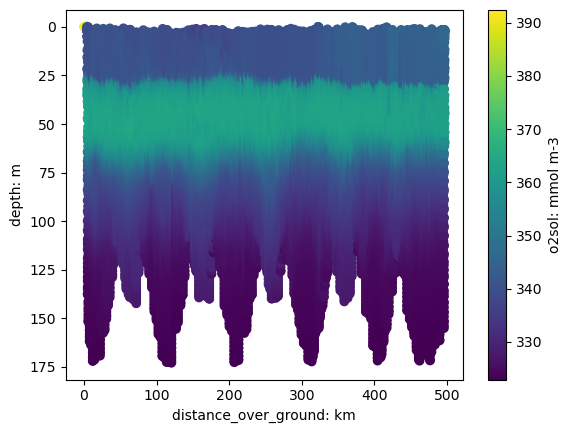

In [23]:
#   Oxygen solubility, as defined by physical properties of the water
property_property(nrt, 'distance_over_ground', 'depth', 'o2sol', savename="reporting/o2sol.png")

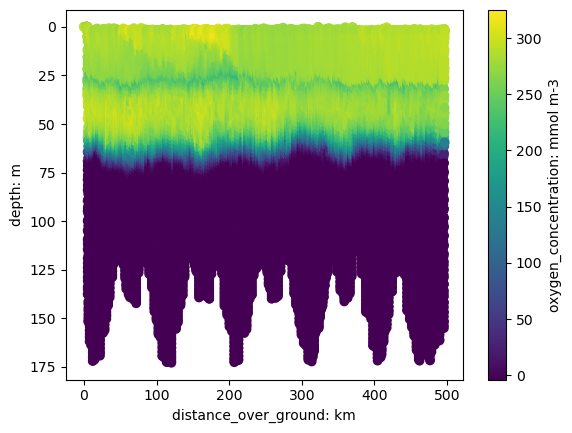

In [24]:
property_property(nrt, 'distance_over_ground', 'depth', 'oxygen_concentration', savename="reporting/o2.png")

In [25]:
logger.info("All the plots have been written out.")

Ok, so now we've got a few figures that we should consider writing out. In Sphinx, I always did 3 things with ODF:
1. PDF latex (which was the most anal)
2. HTML (which was probably the most flexible)
3. Simpletext (which was the most bandwidth-efficient but didn't have figures or fancy formatting)

For our purposes, I think we should start with PDF and eventually we can just use Simpletext. But we need to generate some `.rst` first.
* Include a QC summary, deets, essential figures, and the logs.

In [26]:
#  Eventually turn this into a function
title = "Summary of QC Results"

threshold = 0.5  #   °C check tolerance from before
count = np.sum(high_deviation).item()  #  Something in general to return

with open("reporting/qc_log.txt", "r") as f:
    lines = [line.rstrip("\n") for line in f]   #  Could pull this out into own .rst section and dump in the appendix
    lines = "\n\n".join(lines)

content = f"""
{title}
{'=' * len(title)}

QC Summary
----------

- Points flagged as bad: **{count}**
- Median threshold used: {threshold}

Details
-------

The temperature QC was applied after median filtering.

New flags: {xr_describe(nrt["temperature_qc_qartod"])}

Old flags: {xr_describe(nrt["temperature_qc"])}

Figures
-------

.. image:: temperature_delta.png
   :alt: Temperature difference from median filtered signal.
   :width: 400px
   :align: center

.. image:: temperature_flag_example.png
   :alt: Visualization of original and QARTOD QC flags for temperature.
   :width: 400px
   :align: center   

.. subfigure:: AA|BC
   :layout-sm: A|B|C
   :gap: 8px
   :subcaptions: above
   :name: myfigure
   :class-grid: outline

   .. image:: o2.png
      :alt: Observed oxygen.

   .. image:: o2sol.png
      :alt: Oxygen solubility, as calculated by GSW.

   .. image:: aou.png
      :alt: Apparent oxygen utilization (AOU). What happens if I make this "caption" really hecking long like aaaaaaaaaaaaa does this wrap or is it going to shove itself into the other stuff on a single line. If so, this extension might need to be used with a limit on the character length.
   

.. image:: o2.png
   :alt: Observed oxygen.
   :width: 500px
   :align: center

.. image:: o2sol.png
   :alt: Oxygen solubility, as calculated by GSW.
   :width: 500px
   :align: center

.. image:: aou.png
   :alt: Apparent oxygen utilization (AOU).
   :align: center
   :width: 500px

Log
---
{lines}

"""

with open("reporting/qc_summary.rst", "w") as f:
    f.write(content)
logger.info("Summary .rst written out.")

When this has been run, I should just be able to run sphinx in the `reporting` folder.

* `sphinx-quickstart`
* `make latexpdf`

Alternatively
* `make html`

Reminder to install latexmk...

I added an extension `sphinx_subfigure` to this. Get it with pip the same way you would the **rtd** theme or other extensions.

Question: Do we want to include previous PDFs? If so, that will require another extension to plug them into an existing `index.rst`.

This generates a report that is probably a little verbose and might need some formatting tweaks (not using quickstart) but this is how I've used Sphinx for documentation before.

Things to consider down the line:
* Having Sphinx in the pipeline during this routine. I.e., not needing to do `sphinx-quickstart` and instead having a QC boilerplate template ready
    * yaml?
* Automatically exporting the report itself elsewhere, or some sort of `cp` command to move the .html or .pdf somewhere else so we don't need the entire _build folder.

In [27]:
!pwd

/home/aaron-mau/Code/voto_glider_qc_all/mau/voto_glider_qc


In [28]:
#   Notebook shell commands - This could probably be turned into a Python script later (shutil/os/subprocess libraries)
!rm -rf reporting/_build    #   Make sure it rebuilds from scratch
!cd reporting/ && make latexpdf
!cp reporting/_build/latex/dataqc.pdf reporting/dataqc.pdf
logger.info("Sphinx build complete, PDF copied to reporting/dataqc.pdf")

Running Sphinx v8.2.3
loading translations [en]... done
making output directory... done
building [mo]: targets for 0 po files that are out of date
writing output... 
building [latex]: all documents
updating environment: [new config] 2 added, 0 changed, 0 removed
3[2Kreading sources... [100%] qc_summary

looking for now-outdated files... none found
pickling environment... done
checking consistency... done
preparing documents... done
copying assets... 
copying TeX support files... Writing evaluated template result to /home/aaron-mau/Code/voto_glider_qc_all/mau/voto_glider_qc/reporting/_build/latex/latexmkjarc
Writing evaluated template result to /home/aaron-mau/Code/voto_glider_qc_all/mau/voto_glider_qc/reporting/_build/latex/latexmkrc
Writing evaluated template result to /home/aaron-mau/Code/voto_glider_qc_all/mau/voto_glider_qc/reporting/_build/latex/make.bat
Writing evaluated template result to /home/aaron-mau/Code/voto_glider_qc_all/mau/voto_glider_qc/reporting/_build/latex/Makefile


##  3. Metadata and spatiotemporal checks
Especially important variables here:
* pressure_qc_qartod (as a precursor to *depth*)
    * Basically just getting rid of impossible values
* time_qc_qartod
* longitude_qc_qartod
    * what is the *max* feasible range for this and latitude? Take a mean, then check if it exceeds that range
* latitude_qc_qartod

If these are wrong, then the data point doesn't fit within the dataset and carries no scientific value. Like, what good is a measurement if you don't know where it was taken.

Then we gotta look through attributes.
* Check if any attributes are blank/' ' with the exception of date modified
* Confirm that all dates are feasible
* Ask Callum if the WMO ID needs to be looked at

In [29]:
nrt['pressure'].attrs

{'accuracy': '0.5',
 'comment': 'ctd pressure sensor',
 'instrument': 'instrument_ctd',
 'long_name': 'water pressure',
 'observation_type': 'measured',
 'positive': 'down',
 'reference_datum': 'sea-surface',
 'resolution': '0.01',
 'source': 'LEGATO_PRESSURE',
 'standard_name': 'sea_water_pressure',
 'units': 'dbar',
 'valid_max': np.float32(1000.0),
 'valid_min': np.float32(0.0),
 'precision': ' ',
 'platform': 'platform',
 'ancillary_variables': ' '}

In [30]:
nrt['time']

<xarray.DataArray 'time' (time: 29094)> Size: 233kB
array(['2025-08-27T06:28:55.004999936', '2025-08-27T06:29:24.409999872',
       '2025-08-27T06:29:55.064000000', ..., '2025-10-03T06:31:02.644000000',
       '2025-10-03T06:31:32.662000128', '2025-10-03T06:32:01.000999936'],
      shape=(29094,), dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 233kB 2025-08-27T06:28:55.004999936 ... ...
    latitude   (time) float64 233kB 58.09 nan nan nan ... 58.12 58.12 58.12
    longitude  (time) float64 233kB 19.73 nan nan nan ... 19.78 19.78 19.79
    depth      (time) float64 233kB -0.04448 -0.04855 -0.04884 ... 1.968 1.989

In [31]:
#   If dpdt > 0, means it's diving. Otherwise climbing (use this to flag excessive rates - not sure what those tolerances should be yet)
pres = nrt.pressure
nrt['dpdt'] = pres.diff('time')

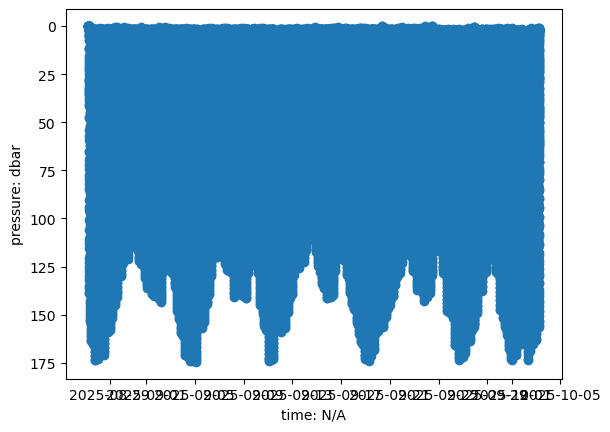

In [32]:
property_property(nrt, 'time', 'pressure')

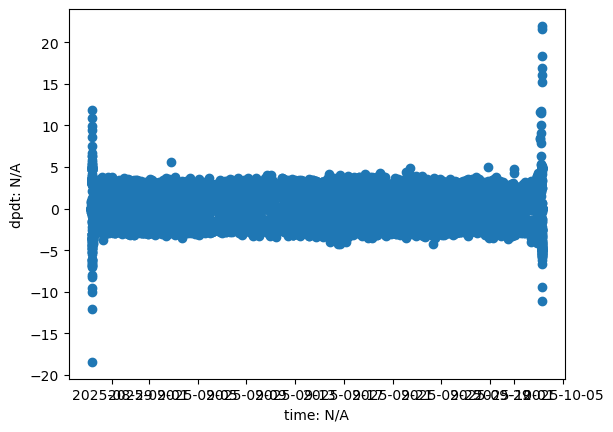

In [ ]:
#   Not sure what the cutoff should be.
property_property(nrt, 'time', 'dpdt')